## **Контекст задачи**

RBC - новостное агентство, один из флагманов российского медиабизнеса. Действуя в конкурентной среде, RBC необходимо оптимизировать ключевые характеристики своих медийных площадок для того, чтобы наращивать рыночную долю.

**Постановка проблемы:**

На основе показателей истории новостей на сайте rbc, разработать модель, которая сможет предсказывать ключевые характеристики будующих публикаций.

**Ключевые харатеристики и их интерпретация:**
1. Views - количество просмотров новости
2. Depth - количество новостей, просмотренных в течение одной сессии
3. Full reads percent - процент читателей дочитавших новость до конца

**Основные гипотезы:**
1. На количество просмотров влияют: тема заголовка, его длинна, сложность для восприятия, количество тегов (определяет количество переходов во время поиска), день недели, месяц
2. На глубину просмотра влияют: день недели, месяц, час
3. На процент дочитавших до конца влияют: тематика, длинна текста, сложность его для восприятия, день недели, час



### Загрузим нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from ast import literal_eval
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH = '/content/drive/MyDrive/Projects/RBK/'

Выполним загрузу датсета

In [4]:
df_train = pd.read_csv(PATH + "train_dataset_train.csv", index_col= False)
df_test = pd.read_csv(PATH + "test_dataset_test.csv", index_col= False)

In [5]:
df_train.head(2)

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,IDE7mtH4RBqGn-8MXfGffQ,[],1.580,5409f11ce063da9c8b588a18,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,35.850
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,KtVJsteHStO5oditt3Uvzw,"['54244e01cbb20f03076b236d','5878a2ec9a7947e53...",1.853,5409f11ce063da9c8b588a12,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,38.355


Данные не содержат непосредственно текстов самих новостей - поэтому будет сложно оценивать их характеристики. Чтобы это восполнить, я спарсил тексты новостей простейшим парсером на основе библиотеки beautiful soup. Код парсера и результат его работы находятся в репозитории.

In [6]:
# загрузим тексты новостей полученные с сайта rbc при помощи парсера
df_corpus = pd.read_csv(PATH + "texts.csv", index_col=False) 

In [7]:
df_corpus.head(3)

,document_id,cat_new,text
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,finances,"[[<div class=""article__text__overview"">\n<span..."
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,politics,"[[<div class=""article__text__overview"">\n<span..."
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,politics,"[[], [<p>Эскалация на Украине не дала повода Ш..."


Для упрощения обработки информации объеденим обучающую и тестовые выборки с корпусом текстов

In [8]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [9]:
df = df.merge(df_corpus, on='document_id')

### Проанализируем получившийся датасет

In [10]:
df.info() # у нас 7000 записей в обучающей выборке и 3000 в тестовой

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   document_id         10000 non-null  object 
 1   title               10000 non-null  object 
 2   publish_date        10000 non-null  object 
 3   session             10000 non-null  object 
 4   authors             10000 non-null  object 
 5   ctr                 10000 non-null  float64
 6   category            10000 non-null  object 
 7   tags                10000 non-null  object 
 8   views               7000 non-null   float64
 9   depth               7000 non-null   float64
 10  full_reads_percent  7000 non-null   float64
 11  cat_new             10000 non-null  object 
 12  text                10000 non-null  object 
dtypes: float64(4), object(9)
memory usage: 1.1+ MB


In [11]:
# выделяем временнЫе характеристики
df['publish_date']=pd.to_datetime(df['publish_date'])

df['year']=df['publish_date'].dt.year
df['month']=df['publish_date'].dt.month
df['day']=df['publish_date'].dt.day
df['weekday']=df['publish_date'].dt.weekday
df['dayofyear']=df['publish_date'].dt.dayofyear
df['hour']=df['publish_date'].dt.hour

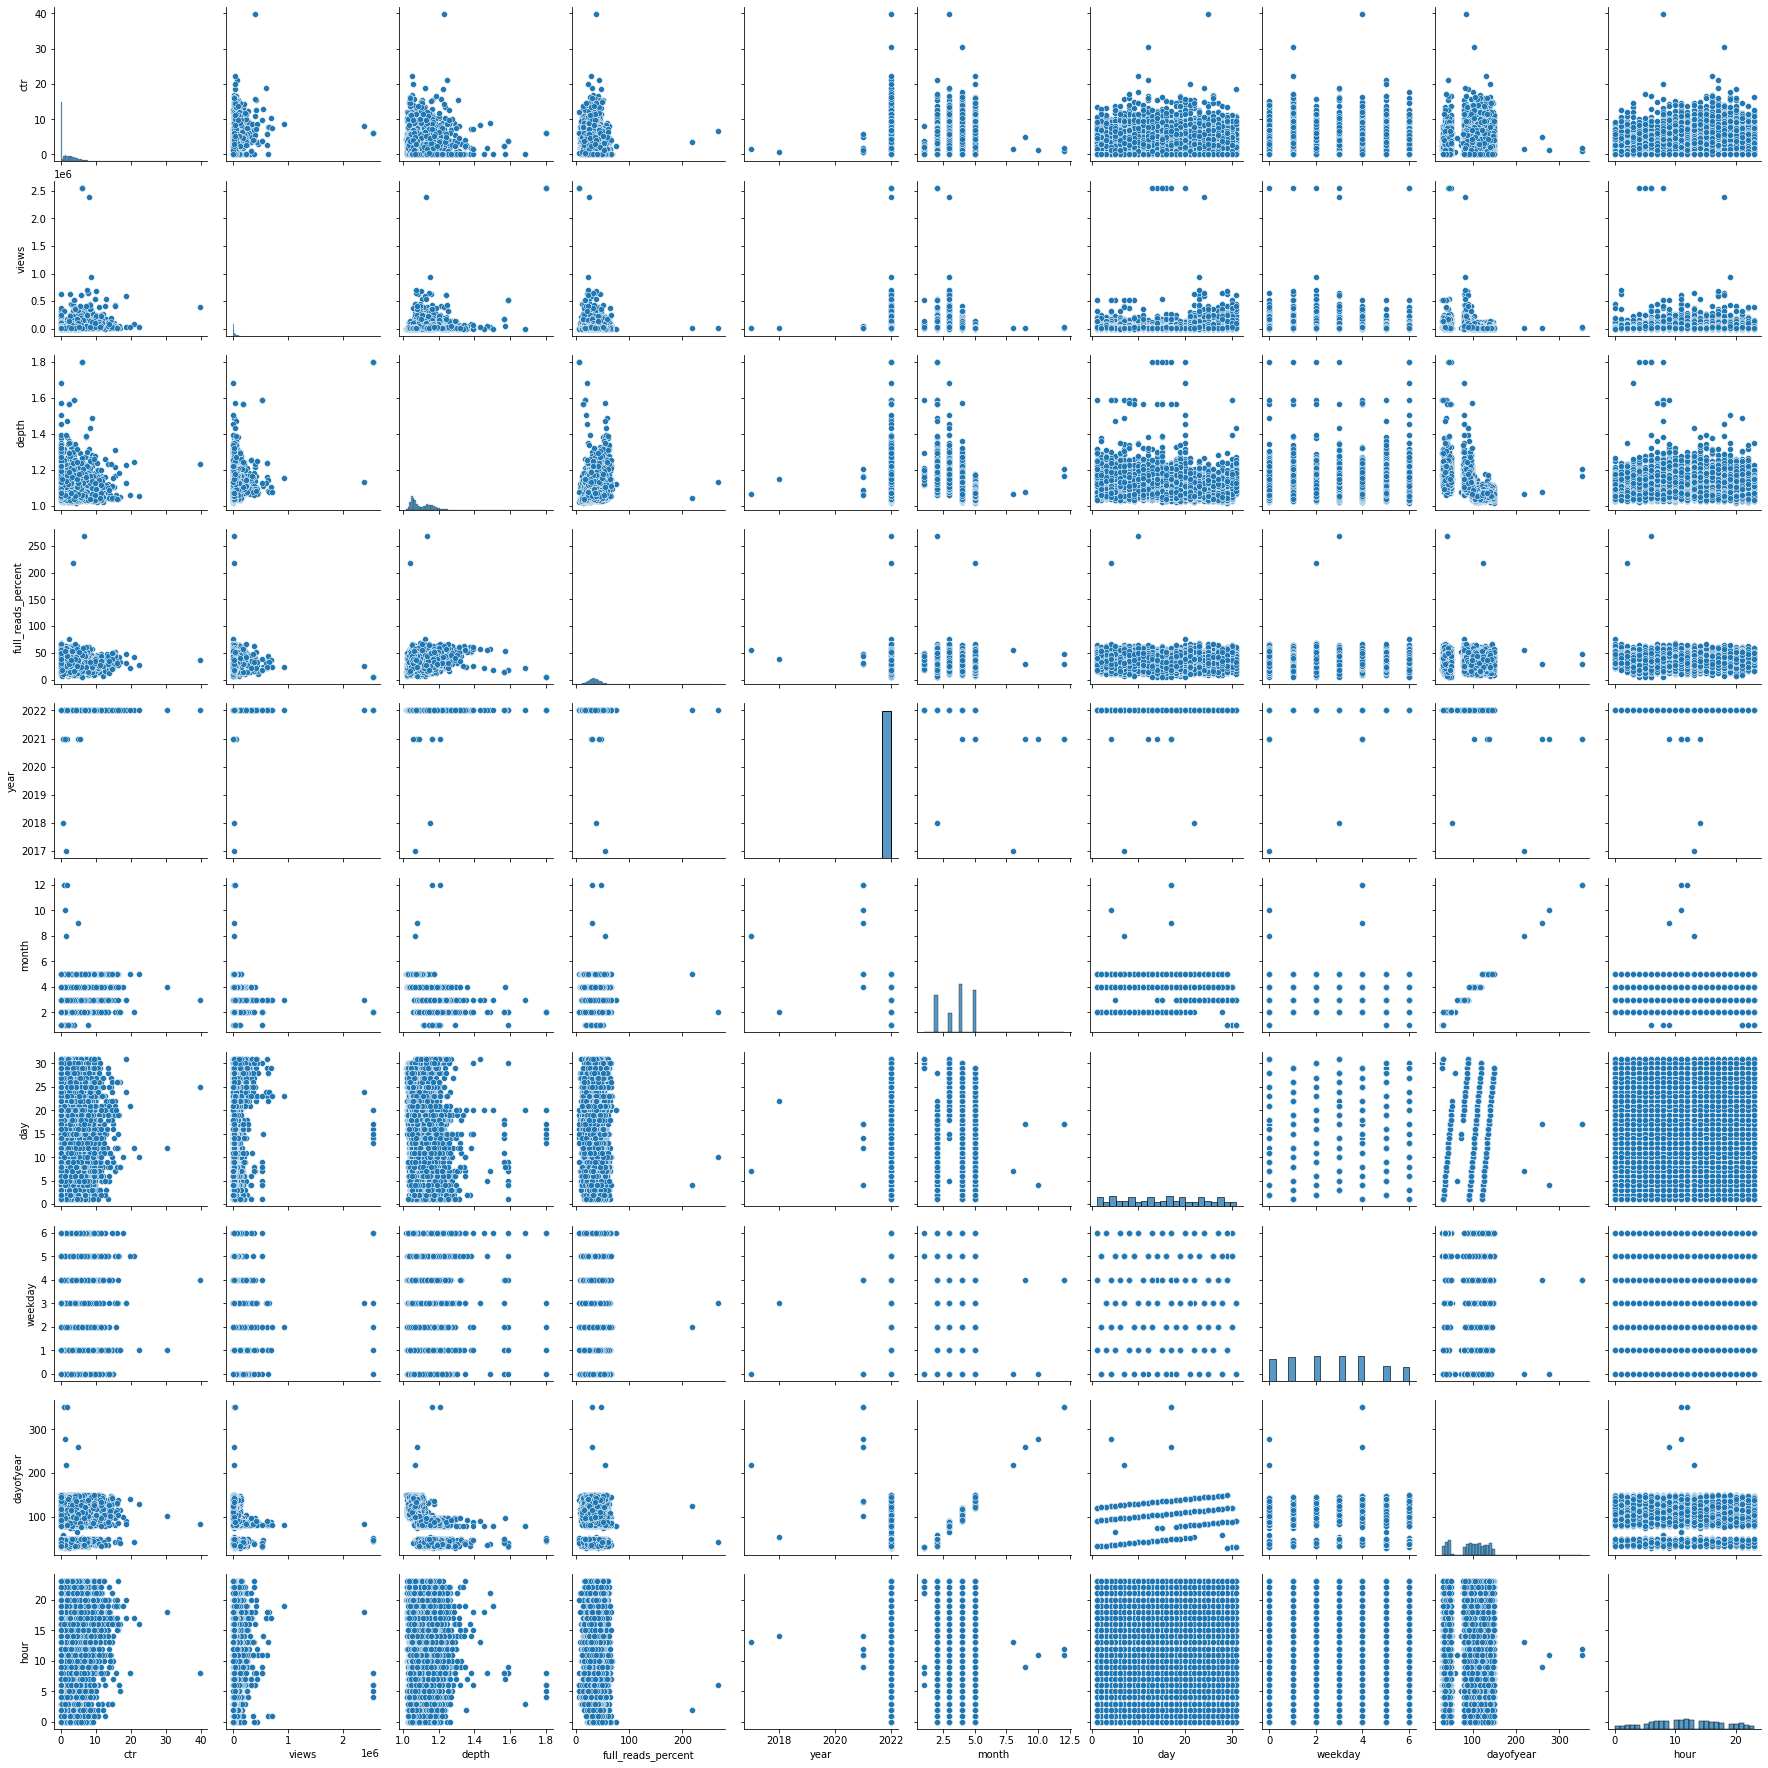

In [12]:
sns.pairplot(df)

Здесь мы отмечаем равномерное распределение по дням, дням недели, часам. 
При этом есть неравномерное распределение по годам, дням года, месяцам.
Отметим выбросы по процентам дочитываемости, просмотрам, ctr. 
Прослеживается зависимость между глубиной просмотра и днем недели. 

In [13]:
df.category.value_counts() # есть категории представленные редко

5409f11ce063da9c8b588a12    5706
5433e5decbb20f277b20eca9    2093
540d5eafcbb20f2524fc0509     940
5409f11ce063da9c8b588a13     491
540d5ecacbb20f2524fc050a     410
5409f11ce063da9c8b588a18     357
5e54e2089a7947f63a801742       1
552e430f9a79475dd957f8b3       1
5e54e22a9a7947f560081ea2       1
Name: category, dtype: int64

In [14]:
# уберем эти три категории, которые встречаются единожды - они содержаться лишь в обучающей выборке и их отсутсвие поможет модели легче обучаться

df = df[~df['category'].isin(['5e54e2089a7947f63a801742', '552e430f9a79475dd957f8b3', '5e54e22a9a7947f560081ea2'])]

In [15]:
# посмотрим на ключевые стат. показатели ключевых переменных
df[['ctr','views', 'depth', 'full_reads_percent']].describe().T

,count,mean,std,min,25%,50%,75%,max
ctr,9997.0,2.238092,2.794725,0.000,0.000,1.381,3.615,39.877
views,6997.0,30361.918822,95496.996071,65.000,5440.000,11969.000,27056.000,2554204.000
depth,6997.0,1.104808,0.065025,1.016,1.055,1.082,1.147,1.799
full_reads_percent,6997.0,34.625563,10.773885,4.978,27.521,34.338,41.370,267.623


Мы видим сильные выбросы в  ctr, views, full reads. Для последнего также видим максимальное значение, которое превышает 100%.

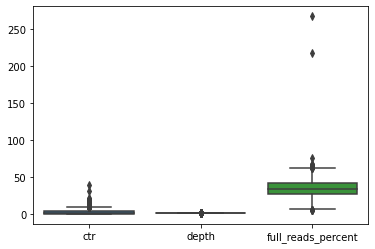

In [16]:
sns.boxplot(data=df[['ctr', 'depth', 'full_reads_percent']])

In [17]:
df[df.full_reads_percent > 100]

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent,cat_new,text,year,month,day,weekday,dayofyear,hour
948,620493199a794737f29908f0wCy2KZoJSJiKDhPixqcYZg,"«Магазины» украденных карт, спор в США из-за с...",2022-02-10 06:01:20,wCy2KZoJSJiKDhPixqcYZg,['57f797ee9a7947a5681d187e'],6.740,5433e5decbb20f277b20eca9,"['5c124ef99a79476e9d0352d3', '5409f294e063daa0...",7107.0,1.133,267.623,society,"[[<div class=""article__text__overview"">\n<span...",2022,2,10,3,41,6
3603,6271d52c9a7947d7db0ac981ciz7jAbTRRGPTfRmXmajDA,«Известия» узнали срок принятия Госдумой закон...,2022-05-04 02:06:12,ciz7jAbTRRGPTfRmXmajDA,['604f2c199a79478ec0029eae'],3.481,5409f11ce063da9c8b588a12,"['5950bd189a7947742cb0489a', '5409f145e063daa0...",6097.0,1.041,217.550,politics,"[[<div class=""article__text__overview"">\n<span...",2022,5,4,2,124,2


In [18]:
# разделим на 10 значение full reads, где оно более 100%
df.full_reads_percent.loc[df.full_reads_percent > 100]=df.full_reads_percent.loc[df.full_reads_percent > 100].apply(lambda x: x/10) 

In [19]:
df[df.views==df.views.max()]

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent,cat_new,text,year,month,day,weekday,dayofyear,hour
2424,62074b119a7947b0e49b36f7LcIC7Zi9RVaJjBx5VlFp3w,Эскалация вокруг Украины. Что известно к 14:00,2022-02-14 04:01:00,LcIC7Zi9RVaJjBx5VlFp3w,[],6.096,5409f11ce063da9c8b588a12,"['5409f196e063daa0f408ae65', '5409f15de063daa0...",2554204.0,1.799,4.978,politics,"[[<div class=""article__text__overview"">\n<span...",2022,2,14,0,45,4
4183,62074b119a7947b0e49b36f7iNdNbeY3TLyxxJmCeU8LdA,Байден попросил россиян не бояться США и НАТО....,2022-02-16 06:42:19,iNdNbeY3TLyxxJmCeU8LdA,[],6.096,5409f11ce063da9c8b588a12,"['5409f196e063daa0f408ae65', '5409f15de063daa0...",2554204.0,1.799,4.978,politics,"[[<div class=""article__text__overview"">\n<span...",2022,2,16,2,47,6
5086,62074b119a7947b0e49b36f72XRjXJ3MR0qlf6Jx-rIRbg,Новое обострение ситуации вокруг Украины. Главное,2022-02-17 06:33:18,2XRjXJ3MR0qlf6Jx-rIRbg,[],6.096,5409f11ce063da9c8b588a12,"['5409f196e063daa0f408ae65', '5409f15de063daa0...",2554204.0,1.799,4.978,politics,"[[<div class=""article__text__overview"">\n<span...",2022,2,17,3,48,6
5634,62074b119a7947b0e49b36f73kkiEgVVT3qV3E7Hd2cDsg,ДНР и ЛНР объявили эвакуацию в Россию. Главное,2022-02-20 08:26:47,3kkiEgVVT3qV3E7Hd2cDsg,[],6.096,5409f11ce063da9c8b588a12,"['5409f196e063daa0f408ae65', '5409f15de063daa0...",2554204.0,1.799,4.978,politics,"[[<div class=""article__text__overview"">\n<span...",2022,2,20,6,51,8
5951,62074b119a7947b0e49b36f7ogeueMGYROCLw1nvmiGQrw,Эскалация вокруг Украины. Что известно к 00:00,2022-02-13 06:01:02,ogeueMGYROCLw1nvmiGQrw,[],6.096,5409f11ce063da9c8b588a12,"['5409f196e063daa0f408ae65', '5409f15de063daa0...",2554204.0,1.799,4.978,politics,"[[<div class=""article__text__overview"">\n<span...",2022,2,13,6,44,6
6359,62074b119a7947b0e49b36f7yeqcRbtLQuCcsxUjWqbUFg,Россия возвращает военных с учений у границ. Г...,2022-02-15 05:05:35,yeqcRbtLQuCcsxUjWqbUFg,[],6.096,5409f11ce063da9c8b588a12,"['5409f196e063daa0f408ae65', '5409f15de063daa0...",2554204.0,1.799,4.978,politics,"[[<div class=""article__text__overview"">\n<span...",2022,2,15,1,46,5


Интересным является факт, что ряд новостей имеют одинаковые показатели ctr, views, depth, full_reads. При этом некоторые из них дублируются. Мы не будем их как-либо обрабатывать, поскольку наш алгоритм сам справится с этим.

In [20]:
df.views.value_counts()

518294.0     7
180456.0     6
2554204.0    6
70873.0      5
119263.0     5
            ..
80100.0      1
9976.0       1
19955.0      1
51152.0      1
11981.0      1
Name: views, Length: 6318, dtype: int64

## **Работа с текстом**

### Очистка текста

In [21]:
!pip install razdel pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 8.6 MB/s 


In [22]:
import re
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
stopword_ru = stopwords.words('russian')

Скачаем дополнительную библиотеку стоп-слов для русского языка

In [24]:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

--2022-07-14 17:27:44--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Resolving drive.google.com (drive.google.com)... 142.250.98.138, 142.250.98.100, 142.250.98.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.98.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rnhr29fqrkad46judjcvdfiprjdrcqr3/1657819650000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=dd6c4f03-a6bc-46a6-9292-970f84948ac9 [following]
--2022-07-14 17:27:44--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rnhr29fqrkad46judjcvdfiprjdrcqr3/1657819650000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=dd6c4f03-a6bc-46a6-9292-970f84948ac9
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 173.194.211.132, 2607

In [25]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
stopword_ru.append('изз') #добавим "слово" изз, которое получается после лемматизации текста
len(stopword_ru)

777

In [26]:
stop_title = stopword_ru  #добави стоп-слова для обработки заголовков новостей - они встречаются в качестве тегов

for i in ["политика", "общество", "бизнес", "город", "экономика", "медиа", "технологии","дискуссионный", "финансы" ]:
  stop_title.append(i)

Очистим тексты полученные парсингом от html кода.

In [27]:
!pip install bleach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import bleach

In [29]:
%%time
from tqdm import tqdm
tqdm.pandas()

df['text'] = df['text'].progress_apply(lambda x: bleach.clean(x, tags=[], strip=True) )


100%|██████████| 9997/9997 [00:57<00:00, 175.30it/s]

CPU times: user 43.1 s, sys: 485 ms, total: 43.6 s
Wall time: 57.1 s


In [30]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [31]:


cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemm_title(text):    
    '''
    лемматизация заголовка
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stop_title] # [6]
    
    return words_lem_without_stopwords

In [32]:
morph = pymorphy2.MorphAnalyzer()

In [33]:

# Запускаем очистку текста. Будет долго...
df['title'] = df['title'].progress_apply(lambda x: clean_text(x))
df['text'] = df['text'].progress_apply(lambda x: clean_text(x))

100%|██████████| 9997/9997 [00:23<00:00, 430.15it/s]


In [34]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
df['title_lem'] = df['title'].progress_apply(lambda x: lemm_title(x))
df['text_lem'] = df['text'].progress_apply(lambda x: lemmatization(x))


100%|██████████| 9997/9997 [02:10<00:00, 76.75it/s]


CPU times: user 2min, sys: 1.05 s, total: 2min 1s
Wall time: 2min 25s


### Модель LDA

Помогает разбить лемматизированные тексты новостей по темам, количество которых мы задаем произвольно.

In [35]:
# сформируем список наших текстов
texts = list(df['text_lem'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [36]:
N_topic = 40 # 

In [37]:
%%time
from gensim.models import LdaModel

# # Обучаем модель на корпусе
# lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=3)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 14.8 µs


In [38]:
# # Сохраняем модель на диск
temp_file = PATH + "model.lda"
# lda.save(temp_file)

# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [39]:
x = lda.show_topics(num_topics=N_topic, num_words=5, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: банк средство система перевод счёт
topic_1: глава россия совет пост республика
topic_2: мужчина произойти ребёнок данные погибнуть
topic_3: область россия российский днр лнр
topic_4: газ рубль оплата валюта счёт
topic_5: сша байден американский китай ядерный
topic_6: помощь ребёнок грузия россия фонд
topic_7: москва центр пожар строительство белоруссия
topic_8: млрд самолёт млн авиакомпания российский
topic_9: путин россия украина российский владимир
topic_10: российский россия санкция против мид
topic_11: чечня кадыров фсб янгулбаев глава
topic_12: уголовный ст руб свобода штраф
topic_13: область обстрел губернатор регион село
topic_14: twitter маск rt телеканал вещание
topic_15: россия москва ядерный сша случай
topic_16: жириновский лдпр владимир состояние партия
topic_17: нато россия безопасность сша ответ
topic_18: макрон франция выборы ле пен
topic_19: россия российский информация сайт роскомнадзор
topic_20: коронавирус covid россия случай новый
topic_21: проект рбк разви

In [40]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [41]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in df['title_lem'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['document_id'] = df['document_id'].values
topic_matrix = topic_matrix[['document_id']+[f'topic_{i}' for i in range(N_topic)]]

CPU times: user 4.74 s, sys: 61 ms, total: 4.81 s
Wall time: 5.11 s


In [42]:
topic_matrix.head()

,document_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_30,topic_31,topic_32,topic_33,topic_34,topic_35,topic_36,topic_37,topic_38,topic_39
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.377765,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,0.0,0.0,0.0,0.0,0.000000,0.156356,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.267134,0.0,0.000000
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.414021,0.0,0.0,0.0,0.000000,0.0,0.450264
3,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,0.0,0.0,0.0,0.0,0.440653,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


## **Генерация признаков**

In [43]:
def avg_words_length(x):
  """
  Функция для расчета средней длинны слов в тексте
  """
  words=x.split()
  if len(words) == 0:
    avg_words_length = 0
  else:
    word_lengths=[len(word) for word in words]
    avg_words_length=sum(word_lengths)/len(words)
  return avg_words_length

In [44]:
df['title_len'] = df.title.apply(len) #рассчитаем длинну текста заголовка
df['title_wc'] =  df.title.apply(lambda x: len(x.split()))#количество слов в заголовке
df['title_avg_wc_len'] =  df.title.apply(avg_words_length) #средняя длинна слов в заголовке

In [45]:
df['text_len'] = df.text.apply(len)#длинна текста
df['text_wc'] = df.text.apply(lambda x: len(x.split()))#количество слов в тексте
df['text_avg_wc_len'] =  df.text.apply(avg_words_length)#средняя длинна слов в тексте


In [46]:
df['title_readability']= df['title_len']/df['title_avg_wc_len']# удобоваримость заголовка как соотношение его длинны на ср. длинну слов
df['textreadability']= df['text_len']/df['text_avg_wc_len']# удобоваримость текста как соотношение его длинны на ср. длинну слов

In [47]:
df['text_len_w']=df['text_len']/df['text_len'].max() # взвешенная длинна каждого текста на максимум среди всех текстов

In [48]:
df.tags[2]

"['5430f451cbb20f73931ecd05', '5409f15de063daa0f408ada8', '5409f196e063daa0f408ae65']"

In [49]:

df['tags_len'] = df.tags.apply(lambda x: len(x)) # длинна тэгов
df['authors_len'] = df.authors.apply(lambda x: len(x)) # длинна "коллектива авторов"

df['title_len'] = df['title_len']/max(df['title_len']) # взвешенная длинна заголовка
df['tags_len'] = df['tags_len']/max(df['tags_len']) # взвешенная длинна тэгов
df['ctr'] = df['ctr']/max(df['ctr']) # взвешенный ctr

df['authors_len'] = df['authors_len']/max(df['authors_len']) # взвешенная длинна аторов

In [50]:
# выделяем временнЫе характеристики
df['publish_date']=pd.to_datetime(df['publish_date'])

df['year']=df['publish_date'].dt.year
df['month']=df['publish_date'].dt.month
df['day']=df['publish_date'].dt.day
df['weekday']=df['publish_date'].dt.weekday
df['dayofyear']=df['publish_date'].dt.dayofyear
df['hour']=df['publish_date'].dt.hour
df['minute'] = df['publish_date'].dt.minute



In [51]:
numerical = ['session', 'authors', 'ctr', 'category', 'tags', 'title_len', 'tags_len', 'authors_len'] # нумерические колонки

dates = ['month', 'day', 'weekday', 'hour', 'minute', 'dayofyear'] # колонки с датами

In [52]:
# взвесим временные характеристики, чтобы можно было считать по ним статистику
df.month = df.month/max(df.month)
df.day = df.day/max(df.day)
df.weekday = df.weekday/max(df.weekday)
df.dayofyear = df.dayofyear/max(df.dayofyear)
df.hour = df.hour/max(df.hour)
df.minute = df.minute/max(df.minute)


In [53]:
# определим категорийные признаки через частоту, с которой они встречаются
df.category = df.category.map(df.category.value_counts()/df.category.value_counts()[0])
df.session = df.session.map(df.session.value_counts()/df.session.value_counts()[0])
df.authors = df.authors.map(df.authors.value_counts()/df.authors.value_counts()[0])
df.tags = df.tags.map(df.tags.value_counts()/df.shape[0])

In [54]:
# рассчитаем статистику по нумерическим признакам

df['sum_num'] = df[numerical].sum(axis=1)
df['mean_num'] = df[numerical].mean(axis=1)
df['std_num'] = df[numerical].std(axis=1)
df['median_num'] = df[numerical].median(axis=1)

df.sum_num = df.sum_num/max(df.sum_num)

In [55]:
# рассчитаем статистику по временным признакам
df['sum_dat'] = df[dates].sum(axis=1)
df['mean_dat']=df[dates].mean(axis=1)
df['std_dat']=df[dates].std(axis=1)
df['med_dat']=df[dates].median(axis=1)

df.sum_dat=df.sum_dat/max(df.sum_dat)

## **Блок моделирования**

In [56]:
df2=df.copy(deep=True) #сделаем копию, чтобы не менять исходные данные

In [57]:
df2 =pd.merge(topic_matrix, df2, 'left') # объединяем данные с матрицей тем новстей

In [99]:
df2.to_csv(PATH+'df_final.csv', index=False)

### Разделим выборки на обучающую и тестовую

In [58]:
train = df2.loc[df2.views.notnull()]
test = df2.loc[df2.views.isnull()]

In [59]:
to_drop = ["title",
           "publish_date", 
           "document_id", 
           'cat_new', 
           'text',
           'title_lem','text_lem', 
            "sum_num", 
           "mean_dat",
           'tags',
           'minute',
           'title_avg_wc_len',
           'title_readability', 
           "views","depth","full_reads_percent"]
y = train[["views","depth","full_reads_percent"]]

X = train.drop(to_drop, axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)


## **CatBoost**

In [60]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [61]:
from catboost import CatBoostRegressor

In [91]:
cb = CatBoostRegressor(iterations=2500, depth=7, verbose=False)
pred = pd.DataFrame() # инициализируем датафрейм куда будем писать предсказания

In [87]:
%%time
cb.fit(X_train, y_train['views'])
pred['views']=cb.predict(X_val)
cb.fit(X_train, y_train['depth'])
pred['depth']=cb.predict(X_val)
cb.fit(X_train, y_train['full_reads_percent'])
pred['full_reads_percent']=cb.predict(X_val)

CPU times: user 6min 28s, sys: 5.18 s, total: 6min 33s
Wall time: 3min 25s


### Оценка модели

In [88]:
def score(pred):
  """
  функция оценки коэффициента детерминированности, принимает на вход датафрейм с предсказаниями
  """  
  score_views = r2_score(y_val["views"], pred['views'])
  score_depth = r2_score(y_val["depth"], pred['depth'])
  score_frp = r2_score(y_val["full_reads_percent"], pred['full_reads_percent'])

  print(score_views, score_depth, score_frp)

  print(0.4 * score_views + 0.3 * score_depth + 0.3 * score_frp)

In [89]:
score(pred)

0.9197670376834518 0.8672538633368578 0.5707525384558902
0.7993087356112051


In [68]:
%%time
from sklearn.model_selection import cross_val_score
score_views = cross_val_score(cb, X, y['views'], cv=10, scoring='r2')
print("r2score views: ", np.mean(score_views))

score_depth= cross_val_score(cb, X, y['depth'], cv=10, scoring='r2')
print("r2score depth: ", np.mean(score_depth))

score_frp = cross_val_score(cb, X, y['full_reads_percent'], cv=10, scoring='r2')
print("r2score frp: ", np.mean(score_frp))

print(0.4 * np.mean(score_views) + 0.3 * np.mean(score_depth) + 0.3 * np.mean(score_frp))



r2score views:  0.7266027074432694
r2score depth:  0.827686870239886
r2score frp:  0.5594676339473705
0.7067874342334848
CPU times: user 1h 4min 40s, sys: 57.8 s, total: 1h 5min 38s
Wall time: 35min 1s


### **XGBoost**

In [69]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
from xgboost import XGBRegressor


In [71]:
xb=XGBRegressor()
pred = pd.DataFrame()

In [72]:
xb.fit(X_train, y_train['views'])
pred['views']=xb.predict(X_val)
xb.fit(X_train, y_train['depth'])
pred['depth']=xb.predict(X_val)
xb.fit(X_train, y_train['full_reads_percent'])
pred['full_reads_percent']=xb.predict(X_val)

[18:22:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [73]:
score(pred)

0.9392103494557277 0.8537169591636529 0.5333775465712347
0.7918124915027573


In [74]:
%%time
from sklearn.model_selection import cross_val_score
score_views = cross_val_score(xb, X, y['views'], cv=10, scoring='r2')
print("r2score views: ", np.mean(score_views))

score_depth= cross_val_score(xb, X, y['depth'], cv=10, scoring='r2')
print("r2score depth: ", np.mean(score_depth))

score_frp = cross_val_score(xb, X, y['full_reads_percent'], cv=10, scoring='r2')
print("r2score frp: ", np.mean(score_frp))

print(0.4 * np.mean(score_views) + 0.3 * np.mean(score_depth) + 0.3 * np.mean(score_frp))

[18:22:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### **LGBM**

In [75]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
from lightgbm import LGBMRegressor # 66.26
lb = LGBMRegressor()
pred = pd.DataFrame()

In [78]:
lb.fit(X_train, y_train['views'])
pred['views']=lb.predict(X_val)
lb.fit(X_train, y_train['depth'])
pred['depth']=lb.predict(X_val)
lb.fit(X_train, y_train['full_reads_percent'])
pred['full_reads_percent']=lb.predict(X_val)

In [79]:
score(pred)

0.7124056008131736 0.790148290033839 0.5519317272363533
0.6875862455063272


In [80]:
%%time
from sklearn.model_selection import cross_val_score
score_views = cross_val_score(lb, X, y['views'], cv=10, scoring='r2')
print("r2score views: ", np.mean(score_views))

score_depth= cross_val_score(lb, X, y['depth'], cv=10, scoring='r2')
print("r2score depth: ", np.mean(score_depth))

score_frp = cross_val_score(lb, X, y['full_reads_percent'], cv=10, scoring='r2')
print("r2score frp: ", np.mean(score_frp))

print(0.4 * np.mean(score_views) + 0.3 * np.mean(score_depth) + 0.3 * np.mean(score_frp))

r2score views:  0.4369962068669113
r2score depth:  0.7894869297567364
r2score frp:  0.5488194404395278
0.5762903938056438
CPU times: user 27.5 s, sys: 486 ms, total: 28 s
Wall time: 35.3 s


## **Предсказание на тестовой выборке**

In [92]:
answers = pd.read_csv(f'{PATH}sample_solution.csv')

In [93]:
X_test = test.drop(to_drop, axis=1)

In [94]:
cb.fit(X_train, y_train['views'])
answers['views']=cb.predict(X_test)
cb.fit(X_train, y_train['depth'])
answers['depth']=cb.predict(X_test)
cb.fit(X_train, y_train['full_reads_percent'])
answers['full_reads_percent']=cb.predict(X_test)

In [95]:
answers.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,15834.342458,1.219893,48.717489
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,3790.829013,1.054919,34.767202
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,12567.779314,1.067875,29.840636
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,4827.623675,1.069286,31.838208
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,177568.537297,1.126205,28.054570


In [96]:
# округлим прогнозные значения
answers.views=answers.views.astype('int64') 
answers.depth = round(answers.depth,3)
answers.full_reads_percent=round(answers.full_reads_percent,3)


In [97]:
answers.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,15834,1.220,48.717
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,3790,1.055,34.767
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,12567,1.068,29.841
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,4827,1.069,31.838
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,177568,1.126,28.055


In [98]:
# запишем предсказания
answers.to_csv(f'{PATH}submission14-07-final.csv', index=False)